<h2>Introduction</h2>

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [12]:
import matplotlib.pyplot as plt

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1939


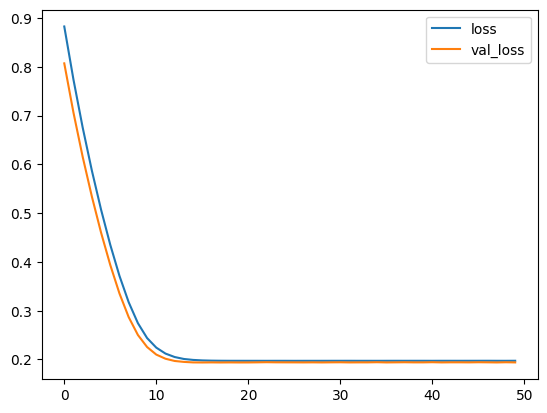

In [14]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1939


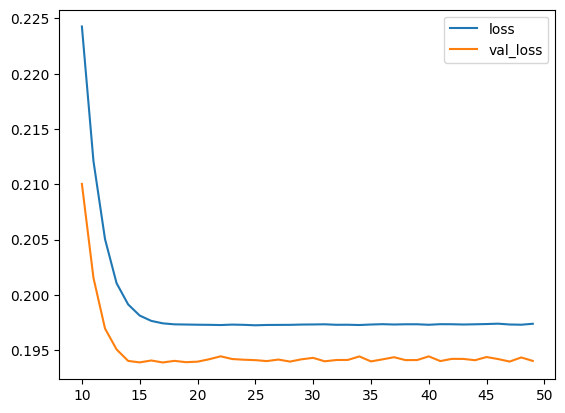

In [15]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2309 - val_loss: 0.2010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993 - val_loss: 0.1984
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1939 - val_loss: 0.1953
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1905 - val_loss: 0.1949
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1898 - val_loss: 0.1946
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1878 - val_loss: 0.1963
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1875 - val_loss: 0.1949
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1875 - val_loss: 0.1940
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1861 - val_loss: 0.1967
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1852 - val_loss: 0.1950
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1834 - val_loss: 0.1954
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1822 - val_lo

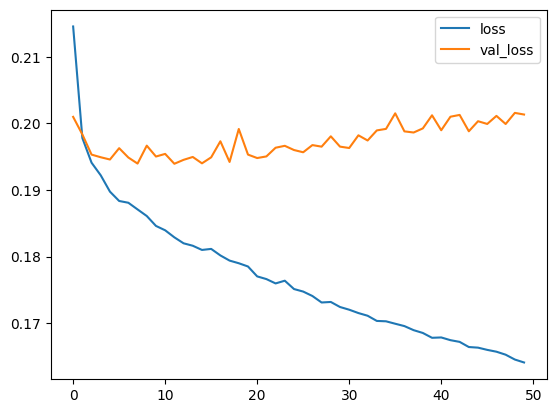

In [16]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

<h3>2) Add Capacity</h3>

What is your evaluation of these curves? Underfitting, overfitting, just right?

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

<h3>3) Define Early Stopping Callback</h3>

Now define an early stopping callback that waits 5 epochs (patience') for a change in validation loss of at least 0.001 (min_delta) and keeps the weights with the best loss (restore_best_weights).

In [17]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Now run this cell to train the model and get the learning curves. Notice the callbacks argument in model.fit.

Epoch 1/50


c:\Users\duong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3104 - val_loss: 0.2026
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2019 - val_loss: 0.1982
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1978 - val_loss: 0.1967
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940 - val_loss: 0.1963
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1928 - val_loss: 0.1957
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1900 - val_loss: 0.1959
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1909 - val_loss: 0.1949
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1879 - val_loss: 0.1943
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1856 - val_loss: 0.1944
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1857 - val_loss: 0.1949
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1851 - val_loss: 0.1956
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1847 - val_loss: 0.1957


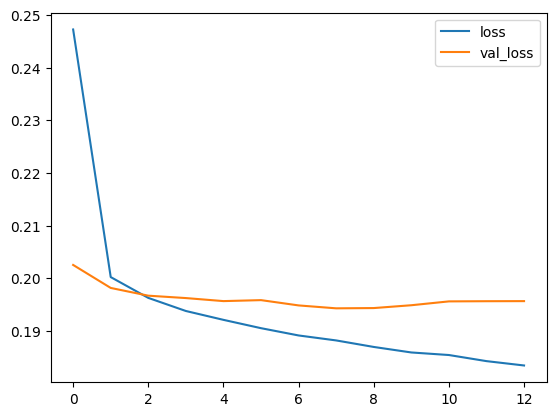

In [18]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

<h3>4) Train and Interpret</h3>

Was this an improvement compared to training without early stopping?

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

If you like, try experimenting with patience and min_delta to see what difference it might make.